In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToPILImage, ToTensor, Resize
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np

import matplotlib.pyplot as plt
plt.ion()   # interactive mode

In [2]:
LATENT_DIM = 5 #size of the latent space in the variational autoencoder
BATCH_SIZE = 128

In [54]:
# helper function for displaying images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
class VAE_simple(nn.Module):
    def __init__(self):
        super(VAE_simple, self).__init__()

        self.fc1 = nn.Linear(3*28*28, 400)
        self.extra_layer = nn.Linear(400, 100)
        self.extra_layer2 = nn.Linear(100, 100)
        self.fc21 = nn.Linear(100, LATENT_DIM)
        self.fc22 = nn.Linear(100, LATENT_DIM)
        
        self.fc3 = nn.Linear(LATENT_DIM, 100)
        self.extra_layer_dec = nn.Linear(100, 100)
        self.extra_layer_dec2 = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 3*28*28)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h1 = self.relu(self.extra_layer(h1))
        h1 = self.relu(self.extra_layer2(h1))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        h3 = self.relu(self.extra_layer_dec(h3))
        h3 = self.relu(self.extra_layer_dec2(h3))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 3*28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
def loss_function(reconstruced_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstruced_x.view(-1, 3*28*28), x.view(-1, 3*28*28))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * (3*28*28)

    return BCE + KLD

In [6]:
my_transform = Compose([ToTensor(), 
                        ToPILImage(), 
                        Resize((28,28)), 
                        ToTensor()])
train_set = ImageFolder(root='train_set', transform=my_transform) #loading images from folder and resize them to 28x28
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

In [7]:
net = VAE_simple()
optimizer = optim.Adam(net.parameters())

In [8]:
net.train() #set the model in the training mode (important for Dropout and BatchNorm)
NUMBER_OF_IMAGES = len(train_set.imgs)

for epoch in range(50):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        reconstructed_batch, mu, logvar = net(inputs)
        
        outputs = net(inputs)
        loss = loss_function(reconstructed_batch, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]*inputs.size(0)

    print('Epoch %d, loss: %.3f' % (epoch + 1, running_loss / NUMBER_OF_IMAGES))
                
print('Finished Training')

Epoch 1, loss: 0.598
Epoch 2, loss: 0.551
Epoch 3, loss: 0.536
Epoch 4, loss: 0.526
Epoch 5, loss: 0.524
Epoch 6, loss: 0.521
Epoch 7, loss: 0.517
Epoch 8, loss: 0.516
Epoch 9, loss: 0.515
Epoch 10, loss: 0.514
Epoch 11, loss: 0.513
Epoch 12, loss: 0.513
Epoch 13, loss: 0.512
Epoch 14, loss: 0.512
Epoch 15, loss: 0.511
Epoch 16, loss: 0.511
Epoch 17, loss: 0.511
Epoch 18, loss: 0.510
Epoch 19, loss: 0.510
Epoch 20, loss: 0.510
Epoch 21, loss: 0.509
Epoch 22, loss: 0.509
Epoch 23, loss: 0.508
Epoch 24, loss: 0.506
Epoch 25, loss: 0.505
Epoch 26, loss: 0.504
Epoch 27, loss: 0.504
Epoch 28, loss: 0.504
Epoch 29, loss: 0.503
Epoch 30, loss: 0.503
Epoch 31, loss: 0.503
Epoch 32, loss: 0.502
Epoch 33, loss: 0.502
Epoch 34, loss: 0.501
Epoch 35, loss: 0.501
Epoch 36, loss: 0.500
Epoch 37, loss: 0.500
Epoch 38, loss: 0.499
Epoch 39, loss: 0.499
Epoch 40, loss: 0.499
Epoch 41, loss: 0.498
Epoch 42, loss: 0.498
Epoch 43, loss: 0.498
Epoch 44, loss: 0.497
Epoch 45, loss: 0.497
Epoch 46, loss: 0.4

# Evaluation
Let's see how our autoencoder reconstructs given images

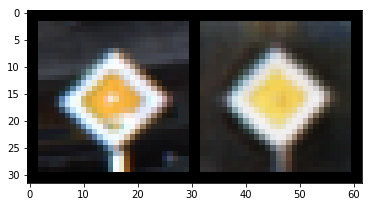

In [33]:
net.eval()
images = [0,0]

output = net(Variable(train_loader.dataset[2000][0].unsqueeze(0)))
images[0] = train_loader.dataset[2000][0] #original image
images[1] = output[0].data.view(3,28,28) # reconstructed image
imshow(torchvision.utils.make_grid(images))

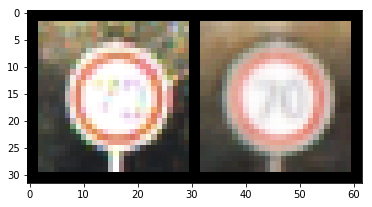

In [34]:
output = net(Variable(train_loader.dataset[3000][0].unsqueeze(0)))
images[0] = train_loader.dataset[3000][0] #original image
images[1] = output[0].data.view(3,28,28) # reconstructed image
imshow(torchvision.utils.make_grid(images))

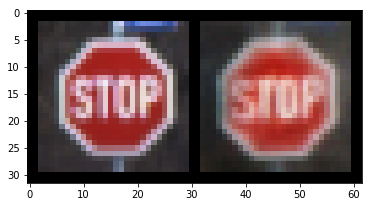

In [40]:
output = net(Variable(train_loader.dataset[2500][0].unsqueeze(0)))
images[0] = train_loader.dataset[2500][0] #original image
images[1] = output[0].data.view(3,28,28) # reconstructed image
imshow(torchvision.utils.make_grid(images))

# Generating images

Now we generate images from random samples taken from normal distribution

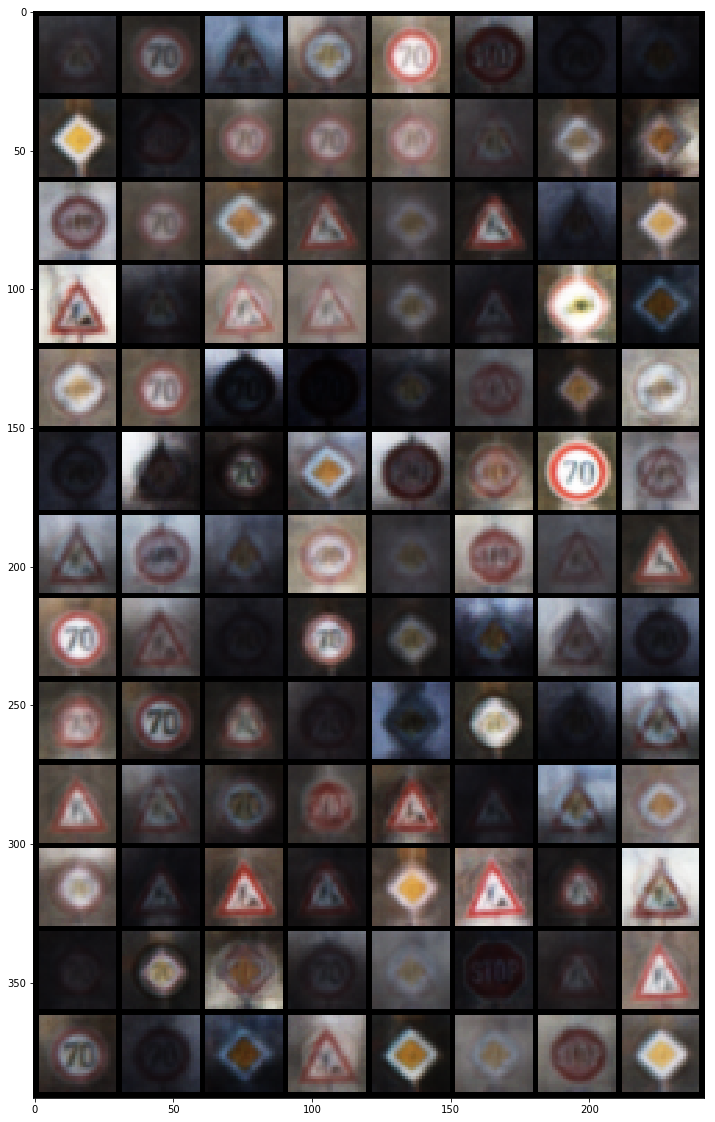

In [59]:
# let's generate 104 images and save it in 13x8 grid
sample = Variable(torch.randn(104, LATENT_DIM))
sample = net.decode(sample)
fig = plt.figure(figsize=(20,20))
imshow(torchvision.utils.make_grid(sample.data.view(104, 3, 28, 28)))